# CLFO
## 03 Convolutional neural network

### Imports

In [1]:
import sys
sys.executable

'c:\\users\\randj\\appdata\\local\\programs\\python\\python38\\python.exe'

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split as split
from torch.utils.data import DataLoader, Dataset

c:\users\randj\appdata\local\programs\python\python38\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\randj\AppData\Local\Programs\Python\Python38\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


### Loading prepared data

In [3]:
with open("tr2_grey_256.npy","rb")as f:
    X=np.load(f)
    y=np.load(f)
    

print(np.unique(y,return_counts=True))


(array([0., 1., 2., 3., 4.]), array([1200, 1200, 1200, 1200, 1200], dtype=int64))


In [4]:
X[0].shape

(256, 256)

In [5]:
X = np.reshape(X, (6000,1,256,256))
X.shape

(6000, 1, 256, 256)

In [6]:
#X = X.astype('float32')
#y = y.astype('float32')

### Model parameters

In [23]:
input_size=X.shape[2]*X.shape[3]
num_classes=5

test_size=0.2
batch_size=12
learning_rate=0.001
hidden_size=100
num_epochs=1

### Spliting train and test size

In [8]:
X_train, X_test, y_train, y_test = split(X, y, test_size = test_size, random_state = 7)

In [9]:
np.unique(y_test, return_counts = True)

(array([0., 1., 2., 3., 4.]), array([230, 224, 253, 248, 245], dtype=int64))

### Transform two numpy arrays into one torch Data instance

In [10]:
class Data(Dataset):
    def __init__(self, X, y):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(y)
        self.samples=X.shape[0]
        self.features=X.shape[2]*X.shape[3]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.samples

### Creating data instance

In [11]:
train_data=Data(X_train, y_train)
test_data=Data(X_test,y_test)

In [12]:
train_data.samples, test_data.samples

(4800, 1200)

In [13]:
train_data[0][0].size()

torch.Size([1, 256, 256])

In [14]:
train_data.features

65536

### Devide train and test data in 100 samples batches

In [15]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size)

In [16]:
len(train_loader)

400

### Example

In [17]:
examples=iter(train_loader)
samples, labels = examples.next()
print(samples.shape, labels)

torch.Size([12, 1, 256, 256]) tensor([4., 1., 3., 0., 0., 2., 1., 1., 1., 1., 4., 0.], dtype=torch.float64)


### Allow GPU usage

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

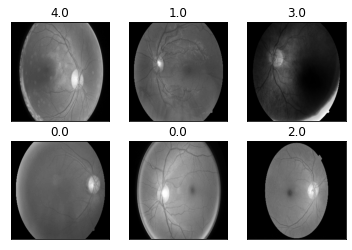

In [19]:
for i in range(6):
    ax = plt.subplot(2,3,i+1, title = f'{labels[i]}') 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(samples[i][0], cmap='gray')
plt.show()

<img src='convolution.png'>

<img src='maxpooling.png'>

In [35]:
learning_rate = 0.01
num_epochs = 1

In [36]:
# convolution_1 -> 252 (sharpen image and reduce dimension by kernel_size - 1)
# max_pool -> 126 (square 2X2 of 4 pixelx transforms into 1 by selecting one with highest value)
# convolution_2 -> 122
# max_pool -> 61
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution1 = nn.Conv2d(1,6,3) # number of color chanels, output nodes, kernel size
        self.pool = nn.MaxPool2d(2) # kernel size (look sketch above), second parameter is stride (default value is kernel size)
        self.convolution2 = nn.Conv2d(6,16,4) # input size must be number of hidden layers (6)
        self.fc1 = nn.Linear(16*62*62, 120) # 16 hidden layers x 61X61 image -> flatten to 16*61*61, 120 is optional
        self.fc2 = nn.Linear(120, 84) # 84 is optional
        self.fc3 = nn.Linear(84, 5) # we have 5 classes
    
    def forward(self, x):
        x = self.pool(F.relu(self.convolution1(x)))
        x = self.pool(F.relu(self.convolution2(x)))
        x = x.view(-1, 16 * 62 * 62)          
        x = F.relu(self.fc1(x))            
        x = F.relu(self.fc2(x))               
        x = self.fc3(x)                       
        return x

### 3. Cross-Entropy - criterion for optimization

Cross-entropy is calculated for all model at once

Training labels are presented as:
Y = [1,0,0]

Probabilities calculated by Softmax:
P = [0.7,0.1,0.2]

Cross-Entropy 
\begin{align}
D(P,Y)=-\frac{1}{N}\sum Y_i\cdot log(P_i) 
\end{align}

Bigger h for x > Softmax values closer to 1 > log(Pi) closer to zero 

In [37]:
model = ConvolutionalNetwork().to(device)
model.double()
criterion = nn.CrossEntropyLoss()

# SGD stochastig gradiant descent
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

### training

In [38]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    #for 48 baches (48X100)
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_total_steps}, Loss: {loss.item():.4f}')
            
print('\n\nfinished training')
PATH = './BW_256.pth'# pyTorch file extension - saves model
torch.save(model.state_dict(), PATH)

Epoch: 1/1, Step: 10/400, Loss: 1.5896
Epoch: 1/1, Step: 20/400, Loss: 1.6381
Epoch: 1/1, Step: 30/400, Loss: 1.6235
Epoch: 1/1, Step: 40/400, Loss: 1.6321
Epoch: 1/1, Step: 50/400, Loss: 1.6144
Epoch: 1/1, Step: 60/400, Loss: 1.5981
Epoch: 1/1, Step: 70/400, Loss: 1.5861
Epoch: 1/1, Step: 80/400, Loss: 1.6319
Epoch: 1/1, Step: 90/400, Loss: 1.6141
Epoch: 1/1, Step: 100/400, Loss: 1.6101
Epoch: 1/1, Step: 110/400, Loss: 1.6005
Epoch: 1/1, Step: 120/400, Loss: 1.5989
Epoch: 1/1, Step: 130/400, Loss: 1.6157
Epoch: 1/1, Step: 140/400, Loss: 1.6266
Epoch: 1/1, Step: 150/400, Loss: 1.6029
Epoch: 1/1, Step: 160/400, Loss: 1.6117
Epoch: 1/1, Step: 170/400, Loss: 1.5983
Epoch: 1/1, Step: 180/400, Loss: 1.6145
Epoch: 1/1, Step: 190/400, Loss: 1.6182
Epoch: 1/1, Step: 200/400, Loss: 1.5976
Epoch: 1/1, Step: 210/400, Loss: 1.6107
Epoch: 1/1, Step: 220/400, Loss: 1.6133
Epoch: 1/1, Step: 230/400, Loss: 1.6058
Epoch: 1/1, Step: 240/400, Loss: 1.6083
Epoch: 1/1, Step: 250/400, Loss: 1.6167
Epoch: 1/

NameError: name 'path' is not defined

In [39]:
PATH = './BW_256.pth'# pyTorch file extension - saves model
torch.save(model.state_dict(), PATH)